<h1 style="text-align:center;">Gaussian Mixture Model</h1>

# Standard imports

In [2]:
import numpy as np

In [1]:
import matplotlib

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns; sns.set()

In [5]:
import IPython

In [6]:
IPython.display.set_matplotlib_formats("svg")

In [9]:
from sklearn.cluster import KMeans

In [10]:
from scipy.spatial.distance import cdist

In [17]:
from sklearn.mixture import GaussianMixture

# Weakness of k-means

In [7]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

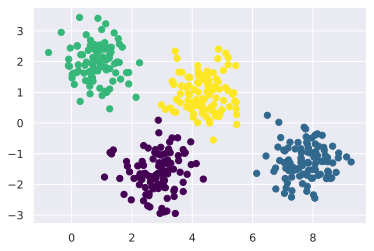

In [8]:
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis");

Custom plot for KMeans result:

In [14]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis("equal")
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis', zorder=2)
    # plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

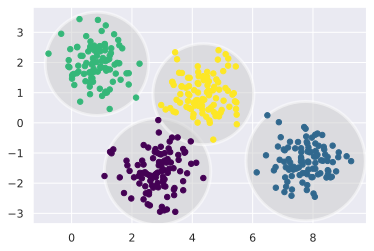

In [15]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

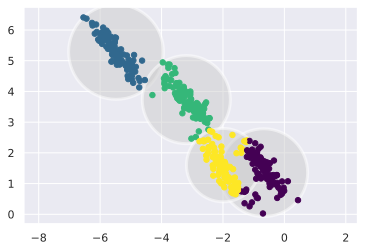

In [16]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

# Generalization of k-means

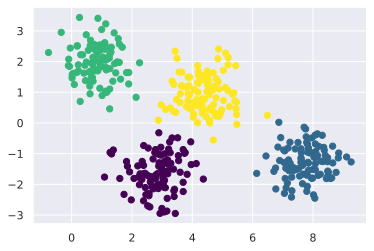

In [18]:
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis");

Probability:

In [19]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


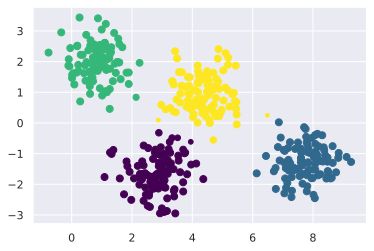

In [20]:
circle_size = 50 * probs.max(1) ** 2 # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=circle_size);

In [23]:
probs.max()

0.9999999999999964

Maximum prob along 2nd axis:

In [26]:
probs.max(1)[:5]

array([0.53076163, 1.        , 1.        , 0.9999084 , 1.        ])

In [27]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [33]:
def plot_gmm(gmm, X, label=True, ax=None):
    
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

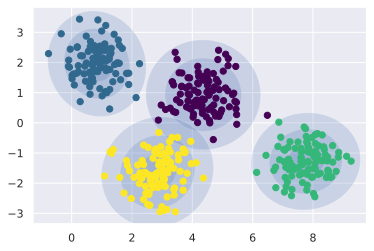

In [34]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

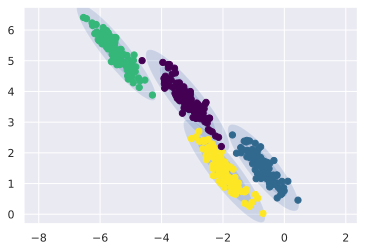

In [35]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

# GMM as Density Estimation

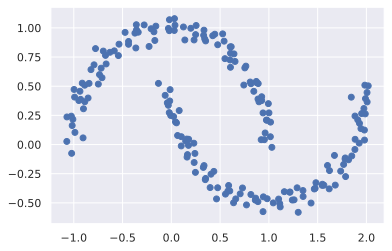

In [36]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

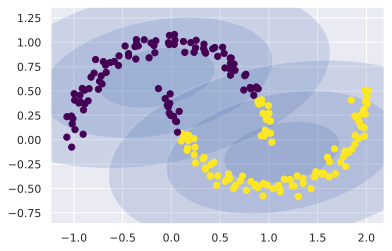

In [37]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

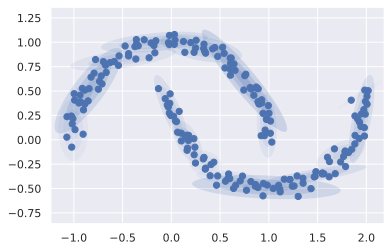

In [38]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.

In [40]:
help(gmm16.sample)

Help on method sample in module sklearn.mixture.base:

sample(n_samples=1) method of sklearn.mixture.gaussian_mixture.GaussianMixture instance
    Generate random samples from the fitted Gaussian distribution.
    
    Parameters
    ----------
    n_samples : int, optional
        Number of samples to generate. Defaults to 1.
    
    Returns
    -------
    X : array, shape (n_samples, n_features)
        Randomly generated sample
    
    y : array, shape (nsamples,)
        Component labels



Function signature of `GaussianMixture.sample` is changed.

In [47]:
Xnew = gmm16.sample( n_samples=400 )[0]

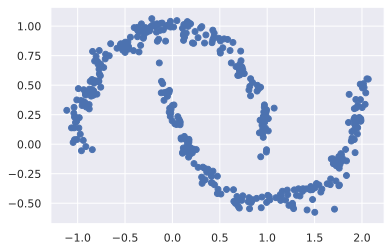

In [48]:
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

# Selecting number of components

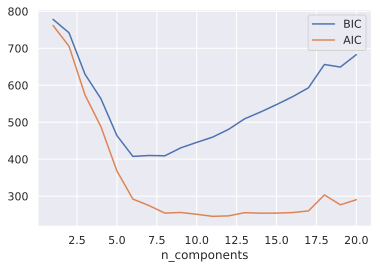

In [68]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type="full", random_state=0).fit(Xmoon) for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label="BIC")
plt.plot(n_components, [m.aic(Xmoon) for m in models], label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components");
plt.grid(True)

# Generate new data: digits dataset

In [51]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [52]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

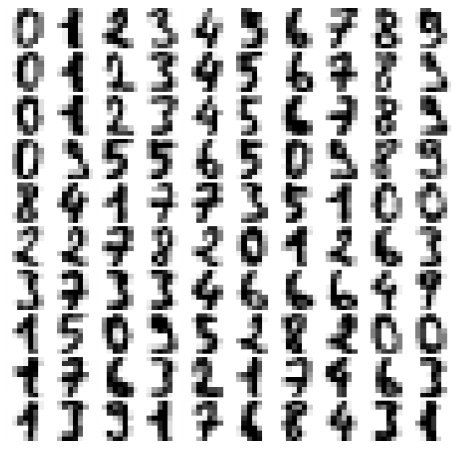

In [53]:
plot_digits(digits.data)

## Reduce the dimensionality

In [54]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

Features are reduced from 64 to 41.

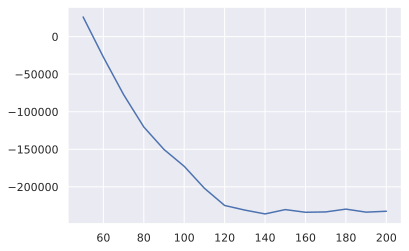

In [56]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 110 components minimizes the AIC; we will use this model.

**FIXME**: the result is quite different from the old version.

In [65]:
gmm = GaussianMixture(120, covariance_type="full", random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [66]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

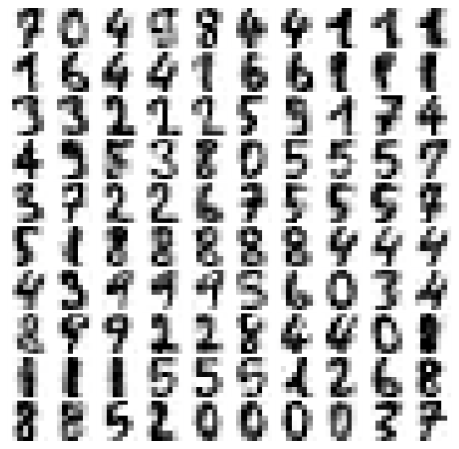

In [67]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)